# Evaluation of Language Model Predictions

This notebook focuses on evaluating and comparing the performance of language models on two different datasets: one related to cars and another related to sleep. The evaluation process involves several key steps:

## Dataset Preparation
- Multiple datasets are loaded, including:
  - Original datasets for cars and sleep questions
  - Predictions made by a base model for both topics
  - Predictions made using RAG (Retrieval-Augmented Generation) for both topics

## Evaluation Process
1. **Comparison of Predictions**
   - Each prediction is compared to the actual answer
   - A rating system (1-5) is used to assess accuracy
   - Brief explanations are provided for each rating

2. **Comparison of Different Models**
   - Base model predictions are compared with RAG-enhanced predictions
   - This comparison helps understand the impact of RAG on prediction quality

3. **Statistical Analysis**
   - Descriptive statistics are calculated for prediction ratings
   - Metrics include mean, standard deviation, and quartiles

## Visualization and Reporting
- Results are presented in tables and graphs
- The analysis compares performance across different question types and prediction methods

## Additional Notes
- Integration with Groq API for evaluation
- Since most LLMs suffer from the first answer syndrome, we do 2 evaluations:
  1. Direct comparison of prediction and actual answer
  2. Indirect comparison by swapping prediction and actual answer
- With that we try to mitigate the effects of the first answer syndrome

# Key Findings
- RAG does not improve (degrades) the quality of predictions for most questions
- Automatic evaluation of predictions can be unreliable, so we need human evaluation (luckily here we only test on ~27 records)


In [1]:
BASE_PATH = ".."

In [33]:
import os
import json

import torch  # type: ignore
import numpy as np  # type: ignore
import pandas as pd  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import seaborn as sns  # type: ignore
import scipy.stats as stats  # type: ignore

from datasets import DatasetDict, Dataset  # type: ignore

from tqdm.auto import tqdm  # type: ignore

from datasets import Dataset, DatasetDict  # type: ignore

from groq import Groq  # type: ignore
from dotenv import load_dotenv  # type: ignore

# Compare with Groq

In [12]:
PROMPTS = {
    "compare_predictions": """Compare the following prediction with the actual answer for the given question:

Question: {question}
Prediction: {pred}
Actual Answer: {actual}

Evaluate the prediction's accuracy and provide a brief explanation. 
Rate the prediction on a scale of 1-5, where 1 is completely incorrect and 5 is perfectly accurate.

Response format should be JSON:
{{
    "rating": [1-5],
    "explanation": [Your explanation here]
}}
""",
    "compare_answers": """Compare the following two answers for the given question:

Question: {question}
Answer 1: {answer1}
Answer 2: {answer2}

Rate the answers on a scale of 1-5, where 1 is completely incorrect and 5 is perfectly accurate.

Response format should be JSON:
{{
    "rating_answer1": [1-5],
    "rating_answer2": [1-5],
    "explanation": [Your explanation here]
}}
""",
}

In [4]:
# Load environment variables from variables.env file
load_dotenv(f"{BASE_PATH}/variables.env")

# Access the GROQ_API_KEY
groq_api_key = os.getenv("GROQ_API_KEY")

# Verify that the key was loaded
if groq_api_key:
    print("GROQ API key loaded successfully.")
else:
    print("Failed to load GROQ API key.")

GROQ API key loaded successfully.


In [5]:
client = Groq(api_key=groq_api_key)

In [26]:
def load_data(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)
    return data


def to_dataset(data):
    restructured_data = {
        "question": [],
        "answer": [],
    }

    for qna in data:
        restructured_data["question"].append(qna["question"])
        if "text" in qna:
            restructured_data["answer"].append(qna["text"])
        else:
            restructured_data["answer"].append(qna["answer"])

    return Dataset.from_dict(restructured_data)


def prepare_dataset(base_path=None):
    test_cars = load_data(f"{base_path}/data/test_qa_car.json")
    test_sleep = load_data(f"{base_path}/data/test_qa_sleep.json")

    cars_predictions = load_data(f"{base_path}/data/cars_predictions.json")
    sleep_predictions = load_data(f"{base_path}/data/sleep_predictions.json")

    cars_rag_predictions = load_data(f"{base_path}/data/cars_rag_predictions.json")
    sleep_rag_predictions = load_data(f"{base_path}/data/sleep_rag_predictions.json")

    test_cars_dataset = to_dataset(test_cars)
    test_sleep_dataset = to_dataset(test_sleep)

    cars_predictions_dataset = to_dataset(cars_predictions)
    sleep_predictions_dataset = to_dataset(sleep_predictions)
    cars_rag_predictions_dataset = to_dataset(cars_rag_predictions)
    sleep_rag_predictions_dataset = to_dataset(sleep_rag_predictions)

    return {
        "cars": test_cars_dataset,
        "sleep": test_sleep_dataset,
        "cars_predictions": cars_predictions_dataset,
        "sleep_predictions": sleep_predictions_dataset,
        "cars_rag_predictions": cars_rag_predictions_dataset,
        "sleep_rag_predictions": sleep_rag_predictions_dataset,
    }

In [27]:
dataset = prepare_dataset(BASE_PATH)
dataset

{'cars': Dataset({
     features: ['question', 'answer'],
     num_rows: 26
 }),
 'sleep': Dataset({
     features: ['question', 'answer'],
     num_rows: 27
 }),
 'cars_predictions': Dataset({
     features: ['question', 'answer'],
     num_rows: 26
 }),
 'sleep_predictions': Dataset({
     features: ['question', 'answer'],
     num_rows: 27
 }),
 'cars_rag_predictions': Dataset({
     features: ['question', 'answer'],
     num_rows: 26
 }),
 'sleep_rag_predictions': Dataset({
     features: ['question', 'answer'],
     num_rows: 27
 })}

In [13]:
# we make 3 comparisons
# 1 - when we tell model which response is ground truth
# 2 - when we don't tell it which response is ground truth just ask to compare
# 3 - when we do same as previous but swap predicted and ground truth places
def compare_predictions(predictions, actual_answers, task_type="compare_predictions"):
    results = []
    for pred, actual in tqdm(zip(predictions, actual_answers), total=len(predictions)):
        assert pred["question"] == actual["question"]

        question = pred["question"]
        prompt = PROMPTS[task_type].format(question=question, pred=pred["answer"], actual=actual["answer"])
        response = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model="llama-3.1-70b-versatile",
            response_format={"type": "json_object"},
            temperature=0.5,
            max_tokens=512,
        )

        results.append(response.choices[0].message.content)

    return results

In [14]:
def compare_answers(predictions, actual_answers, task_type="compare_answers"):
    results = []
    for pred, actual in tqdm(zip(predictions, actual_answers), total=len(predictions)):
        assert pred["question"] == actual["question"]

        question = pred["question"]

        responses = {"direct": None, "swap": None}

        def evaluate_response(answer1, answer2):
            prompt = PROMPTS[task_type].format(question=question, answer1=answer1, answer2=answer2)
            response = client.chat.completions.create(
                messages=[
                    {
                        "role": "user",
                        "content": prompt,
                    }
                ],
                model="llama-3.1-70b-versatile",
                response_format={"type": "json_object"},
                temperature=0.5,
                max_tokens=512,
            )
            return response.choices[0].message.content

        responses["direct"] = evaluate_response(pred["answer"], actual["answer"])
        responses["swap"] = evaluate_response(actual["answer"], pred["answer"])
        results.append(responses)

    return results

In [15]:
cars_comparison_results = compare_predictions(dataset["cars_predictions"], dataset["cars"])

  0%|          | 0/26 [00:00<?, ?it/s]

In [16]:
sleep_comparison_results = compare_predictions(dataset["sleep_predictions"], dataset["sleep"])

  0%|          | 0/27 [00:00<?, ?it/s]

In [19]:
cars_comparison_results_answer = compare_answers(dataset["cars_predictions"], dataset["cars"])
sleep_comparison_results_answer = compare_answers(dataset["sleep_predictions"], dataset["sleep"])

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

In [48]:
cars_rag_comparison_results = compare_predictions(dataset["cars_rag_predictions"], dataset["cars"])
sleep_rag_comparison_results = compare_predictions(dataset["sleep_rag_predictions"], dataset["sleep"])

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

In [29]:
cars_rag_comparison_results_answer = compare_answers(dataset["cars_rag_predictions"], dataset["cars"])
sleep_rag_comparison_results_answer = compare_answers(dataset["sleep_rag_predictions"], dataset["sleep"])

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

In [34]:
def results_to_dataframe(results):
    df_data = []
    for result in results:
        direct = json.loads(result["direct"])
        swap = json.loads(result["swap"])
        df_data.append({
            "pred_1": direct["rating_answer1"], 
            "actual_1": direct["rating_answer2"], 
            "pred_2": swap["rating_answer2"], 
            "actual_2": swap["rating_answer1"], 
            "direct_explanation": direct["explanation"], 
            "swap_explanation": swap["explanation"]
        })
    return pd.DataFrame(df_data)


cars_df = results_to_dataframe(cars_comparison_results_answer)
sleep_df = results_to_dataframe(sleep_comparison_results_answer)
cars_rag_df = results_to_dataframe(cars_rag_comparison_results_answer)
sleep_rag_df = results_to_dataframe(sleep_rag_comparison_results_answer)

In [36]:
# save to csv
cars_df.to_csv(f"{BASE_PATH}/data/cars_evaluation.csv", index=False)
sleep_df.to_csv(f"{BASE_PATH}/data/sleep_evaluation.csv", index=False)
cars_rag_df.to_csv(f"{BASE_PATH}/data/cars_rag_evaluation.csv", index=False)
sleep_rag_df.to_csv(f"{BASE_PATH}/data/sleep_rag_evaluation.csv", index=False)

In [38]:
cars_df.describe()

,pred_1,actual_1,pred_2,actual_2
count,26.000000,26.000000,26.000000,26.000000
mean,4.538462,3.692308,3.846154,4.000000
std,0.811456,1.192283,1.347362,1.019804
min,2.000000,1.000000,1.000000,1.000000
25%,4.000000,3.000000,3.000000,4.000000
50%,5.000000,4.000000,5.000000,4.000000
75%,5.000000,4.750000,5.000000,4.750000
max,5.000000,5.000000,5.000000,5.000000


In [40]:
cars_rag_df.describe()

,pred_1,actual_1,pred_2,actual_2
count,26.000000,26.000000,26.000000,26.000000
mean,3.961538,3.923077,3.576923,4.230769
std,1.482721,1.128648,1.677452,1.142198
min,1.000000,1.000000,1.000000,1.000000
25%,3.250000,4.000000,2.000000,4.000000
50%,5.000000,4.000000,4.500000,5.000000
75%,5.000000,5.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000


In [44]:
ref_cars_df = pd.DataFrame([json.loads(result) for result in cars_comparison_results])
ref_cars_df

,rating,explanation
0,2,The prediction provides some relevant informat...
1,4,"The prediction is mostly accurate, as it ident..."
2,4,The prediction is mostly accurate in explainin...
3,4,The prediction provides an accurate overview o...
4,3,The prediction is partially accurate as it ack...
5,4,The prediction accurately identifies key facto...
6,4,The prediction generally captures the approach...
7,4,"The prediction is mostly accurate, covering ke..."
8,3,The prediction provides a comprehensive overvi...
9,4,"The prediction is mostly accurate, covering ke..."


In [45]:
ref_sleep_df = pd.DataFrame([json.loads(result) for result in sleep_comparison_results])
ref_sleep_df

,rating,explanation
0,4,The prediction provides a detailed and accurat...
1,4,"The prediction is mostly accurate, as it corre..."
2,4,The prediction provides a detailed and compreh...
3,3,The prediction is partially accurate in statin...
4,4,The prediction provides a comprehensive and ac...
5,4,The prediction is mostly accurate in describin...
6,3,The prediction provides a general overview of ...
7,4,The prediction accurately describes the role o...
8,3,The prediction provides some accurate informat...
9,4,The prediction provided a detailed and mostly ...


In [49]:
ref_cars_rag_df = pd.DataFrame([json.loads(result) for result in cars_rag_comparison_results])
ref_cars_rag_df

,rating,explanation
0,1,The prediction failed to provide any relevant ...
1,4,"The prediction is mostly accurate, as it corre..."
2,4,The prediction is mostly accurate as it highli...
3,3,The prediction provides some accurate informat...
4,2,The prediction provided a lengthy and detailed...
5,3,"The prediction is partially correct, as it ide..."
6,4,The prediction provides a comprehensive and de...
7,4,The prediction is mostly accurate but provides...
8,3,The prediction partially covers the key consid...
9,4,"The prediction is mostly accurate, covering ke..."


In [50]:
ref_sleep_rag_df = pd.DataFrame([json.loads(result) for result in sleep_rag_comparison_results])
ref_sleep_rag_df

,rating,explanation
0,2,The prediction is partially incorrect because ...
1,2,The prediction is incomplete and inaccurate. I...
2,2,The prediction is not entirely accurate as it ...
3,4,The prediction provides a comprehensive overvi...
4,2,The prediction did not address the question di...
5,2,The prediction provided some general informati...
6,4,The prediction provided a detailed explanation...
7,4,The prediction is mostly accurate but lacks so...
8,4,"The prediction is mostly accurate, covering ke..."
9,4,The prediction accurately describes the charac...


In [51]:
ref_cars_df.to_csv(f"{BASE_PATH}/data/ref_cars_evaluation.csv", index=False)
ref_sleep_df.to_csv(f"{BASE_PATH}/data/ref_sleep_evaluation.csv", index=False)
ref_cars_rag_df.to_csv(f"{BASE_PATH}/data/ref_cars_rag_evaluation.csv", index=False)
ref_sleep_rag_df.to_csv(f"{BASE_PATH}/data/ref_sleep_rag_evaluation.csv", index=False)

In [56]:
# Create a summary table of all evaluations
summary_data = {
    'Evaluation': ['Cars', 'Cars RAG', 'Sleep', 'Sleep RAG'],
    'Mean Pred 1': [
        cars_df['pred_1'].mean(),
        cars_rag_df['pred_1'].mean(),
        sleep_df['pred_1'].mean(),
        sleep_rag_df['pred_1'].mean()
    ],
    'Mean Actual 1': [
        cars_df['actual_1'].mean(),
        cars_rag_df['actual_1'].mean(),
        sleep_df['actual_1'].mean(),
        sleep_rag_df['actual_1'].mean()
    ],
    'Mean Pred 2': [
        cars_df['pred_2'].mean(),
        cars_rag_df['pred_2'].mean(),
        sleep_df['pred_2'].mean(),
        sleep_rag_df['pred_2'].mean()
    ],
    'Mean Actual 2': [
        cars_df['actual_2'].mean(),
        cars_rag_df['actual_2'].mean(),
        sleep_df['actual_2'].mean(),
        sleep_rag_df['actual_2'].mean()
    ],
    'Mean Ref Rating*': [
        ref_cars_df['rating'].mean(),
        ref_cars_rag_df['rating'].mean(),
        ref_sleep_df['rating'].mean(),
        ref_sleep_rag_df['rating'].mean()
    ],
    'Mean Swap Rating*': [
        (cars_df['pred_1'].mean() + cars_df['pred_2'].mean()) / 2,
        (cars_rag_df['pred_1'].mean() + cars_rag_df['pred_2'].mean()) / 2,
        (sleep_df['pred_1'].mean() + sleep_df['pred_2'].mean()) / 2,
        (sleep_rag_df['pred_1'].mean() + sleep_rag_df['pred_2'].mean()) / 2
    ]
}

summary_df = pd.DataFrame(summary_data).round(4)
summary_df

,Evaluation,Mean Pred 1,Mean Actual 1,Mean Pred 2,Mean Actual 2,Mean Ref Rating*,Mean Swap Rating*
0,Cars,4.5385,3.6923,3.8462,4.0000,3.1923,4.1923
1,Cars RAG,3.9615,3.9231,3.5769,4.2308,2.6154,3.7692
2,Sleep,4.7407,4.0741,4.2593,4.2593,3.7778,4.5000
3,Sleep RAG,4.7407,4.0000,4.4815,4.1852,3.4074,4.6111


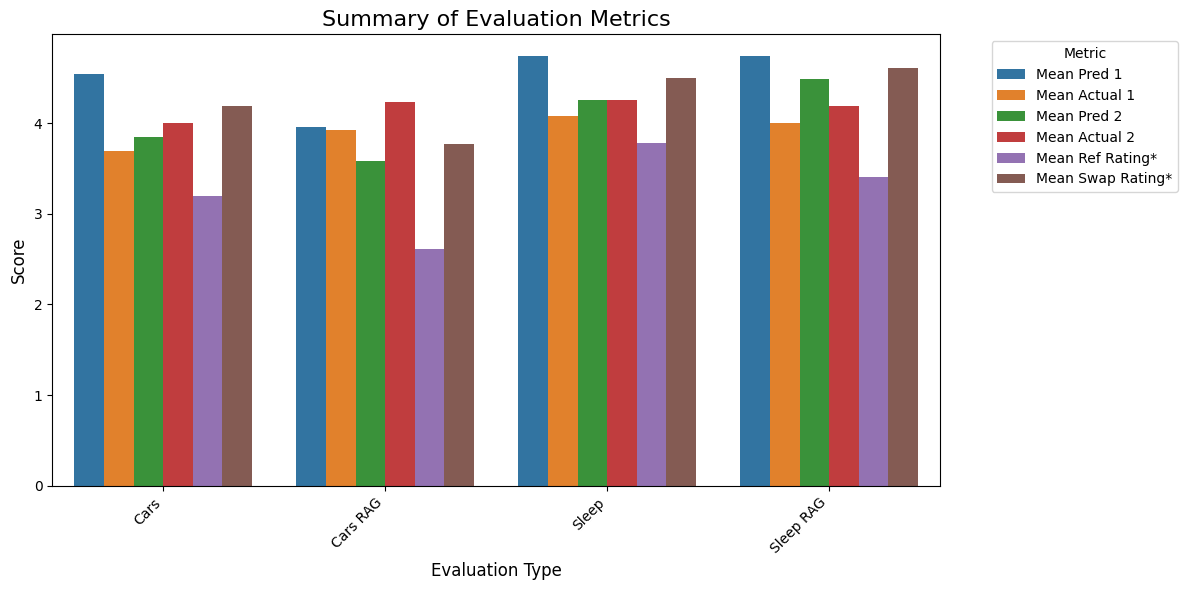

In [62]:
fig, ax = plt.subplots(figsize=(12, 6))

melted_df = summary_df.melt(id_vars=['Evaluation'], 
                            var_name='Metric', 
                            value_name='Score')

sns.barplot(x='Evaluation', y='Score', hue='Metric', data=melted_df, ax=ax)

ax.set_title('Summary of Evaluation Metrics', fontsize=16)
ax.set_xlabel('Evaluation Type', fontsize=12)
ax.set_ylabel('Score', fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [57]:
summary_df.to_csv(f"{BASE_PATH}/data/evaluation_summary.csv", index=False)

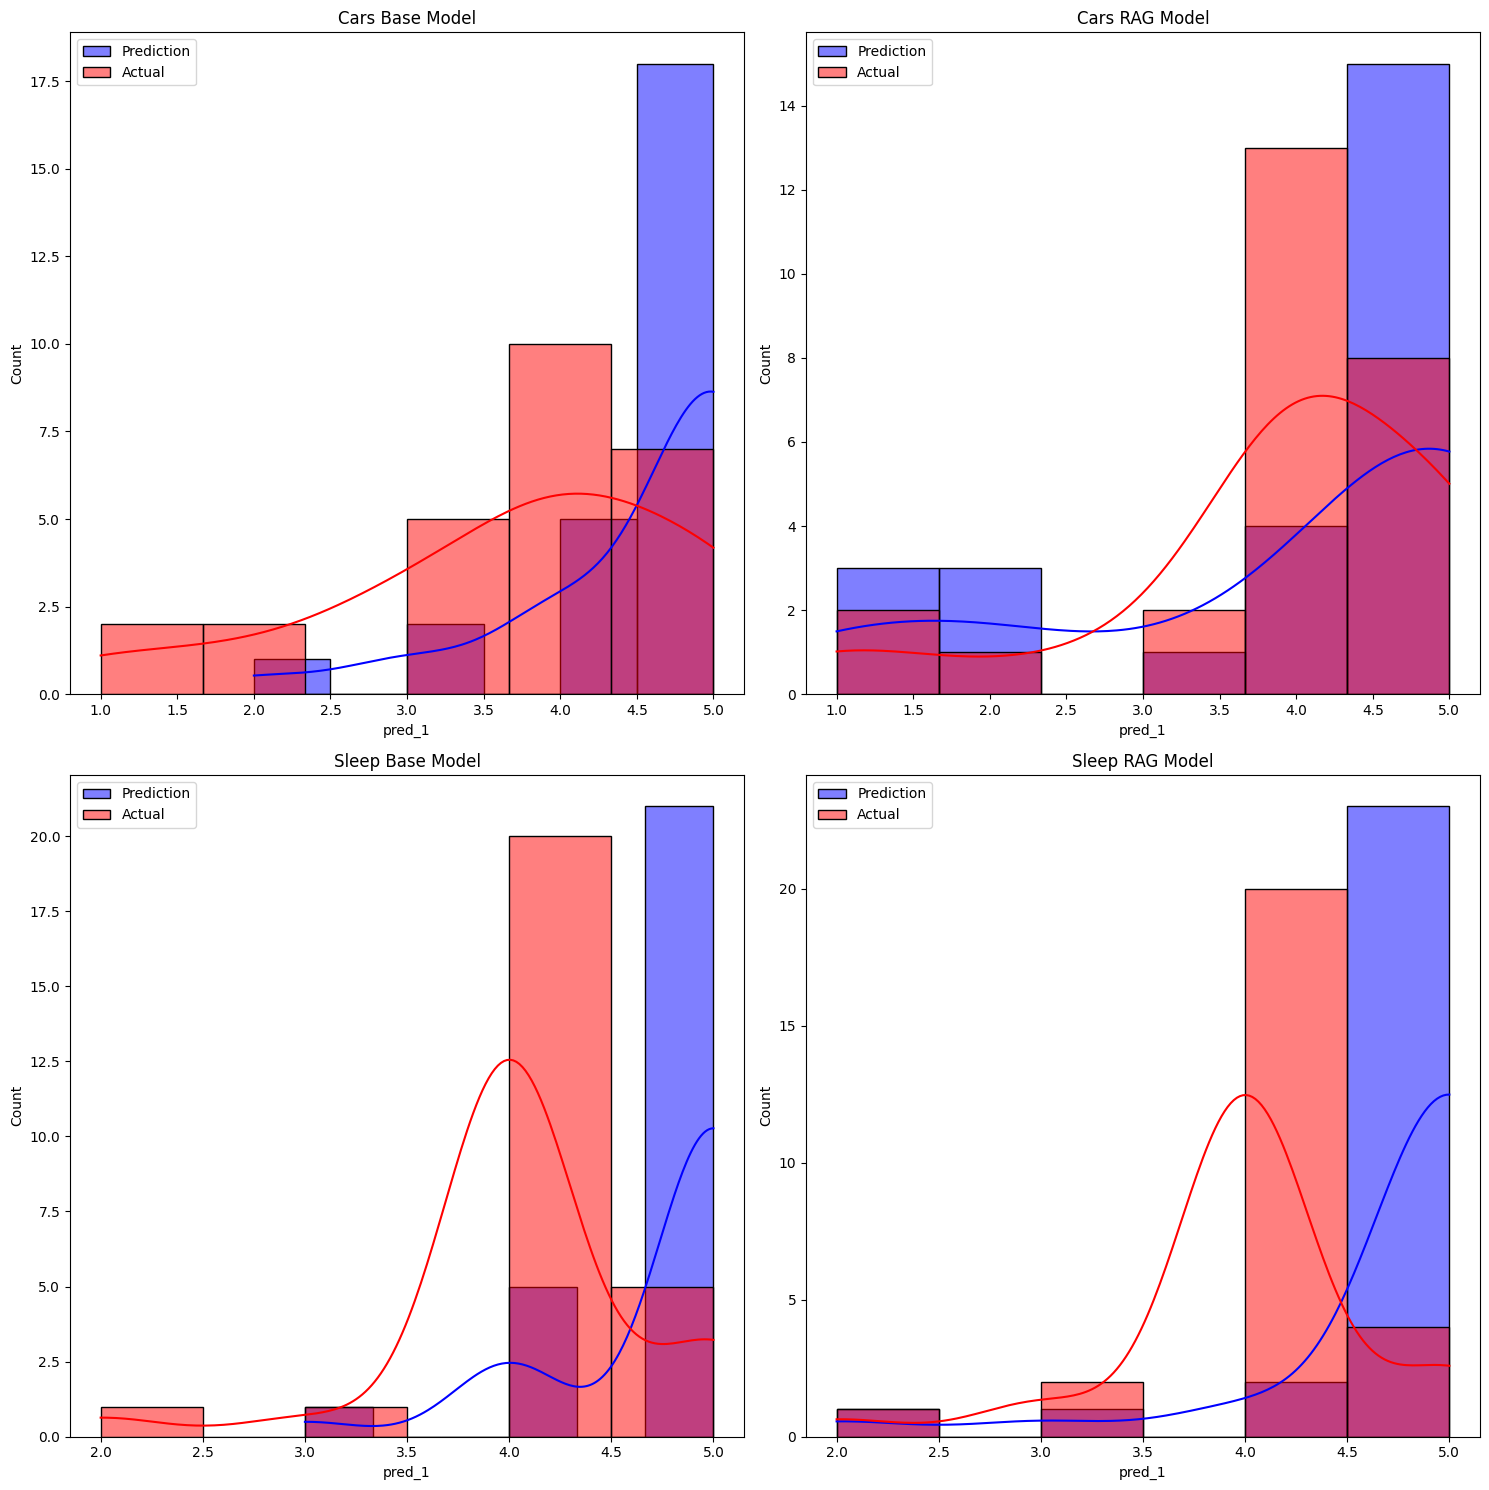

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

def plot_rating_dist(df, ax, title):
    sns.histplot(data=df, x='pred_1', kde=True, color='blue', label='Prediction', ax=ax)
    sns.histplot(data=df, x='actual_1', kde=True, color='red', label='Actual', ax=ax)
    ax.set_title(title)
    ax.legend()

plot_rating_dist(cars_df, axes[0, 0], 'Cars Base Model')
plot_rating_dist(cars_rag_df, axes[0, 1], 'Cars RAG Model')
plot_rating_dist(sleep_df, axes[1, 0], 'Sleep Base Model')
plot_rating_dist(sleep_rag_df, axes[1, 1], 'Sleep RAG Model')

plt.tight_layout()
plt.show()

In [64]:
def calculate_ci(data, confidence=0.95):
    mean = np.mean(data)
    std_err = stats.sem(data)
    margin = std_err * stats.t.ppf((1 + confidence) / 2, len(data) - 1)
    return mean, mean - margin, mean + margin

models = ['Cars Base', 'Cars RAG', 'Sleep Base', 'Sleep RAG']
datasets = [cars_df, cars_rag_df, sleep_df, sleep_rag_df]

for model, df in zip(models, datasets):
    mean, ci_low, ci_high = calculate_ci(df['pred_1'])
    print(f"{model} - Mean: {mean:.2f}, 95% CI: ({ci_low:.2f}, {ci_high:.2f})")

Cars Base - Mean: 4.54, 95% CI: (4.21, 4.87)
Cars RAG - Mean: 3.96, 95% CI: (3.36, 4.56)
Sleep Base - Mean: 4.74, 95% CI: (4.53, 4.95)
Sleep RAG - Mean: 4.74, 95% CI: (4.46, 5.02)
